In [21]:
import numpy as np
import scipy
import torch
from torch import Tensor
from fft_conv import fft_conv
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
import pandas as pd
from time import *
import threading
import warnings
warnings.filterwarnings('ignore')

In [22]:
PATH_TO_PCFs = './in_data/simulations_results/pcf/'
PATH_TO_PARAMs = './in_data/simulations_results/initial_parameters/'
PATH_TO_POPULATION = './in_data/simulations_results/population/'
PATH_TO_OUT_RESULTs = './out_data/result.csv'

In [23]:
def vector_norm(vector):
    return torch.norm(vector)**2


def l1_norm(start_point, end_point, array):
    nodes = np.linspace(start_point, end_point, len(array))
    return scipy.integrate.trapz(torch.abs(array).clone().detach().numpy(), nodes)


class Neumann:
    EPS = 1e-12

    def _calc_step(self):
        sqrt2pi = (2 * np.pi) ** 0.5
        logm = np.log(self.EPS * self.sm * sqrt2pi)
        logw = np.log(self.EPS * self.sw * sqrt2pi)

        if logm > 0 or logw > 0:
            t = 1
        else:
            xm = np.sqrt(-2 * (self.sm ** 2) * logm)
            xw = np.sqrt(-2 * (self.sw ** 2) * logw)
            t = max(xm, xw)

        return t / len(self.GT)
    
    def _calc_disribution(self, sigma):
        lspace = np.linspace(0, self.r, len(self.GT))
        return torch.tensor(scipy.stats.norm.pdf(lspace, scale=sigma))
    
    def __init__(self, GT, sm, sw, b, d, s, x0, r=15, n_iters=15):
        # save params
        self.n_iters = n_iters
        self.r = r
        
        self.b = b
        self.d = d
        self.s = s
        self.sm = sm
        self.sw = sw
        
        self.GT = torch.from_numpy(GT)
        
        # init m, w
        self.m = self._calc_disribution(sm) * self.b
        self.w = self._calc_disribution(sw) * self.s
        
        # step
        self.step = self._calc_step()
        
        #parameters to optimize
        self.x = torch.tensor(x0, requires_grad=True)
        
        self.lr = 0.1
        
        
    def _scalar_product(self, f: Tensor, g: Tensor) -> Tensor:
        w = torch.tensor([self.step] * len(self.GT), dtype=torch.double)
        w[0], w[-1] = [self.step * 0.5] * 2
        return 2 * f @ (w * g)
    
    def _get_convolutions(self, signal: Tensor, kernel: Tensor) -> Tensor:
        f = torch.reshape(signal, [1, 1, signal.size(-1)])
        g = torch.reshape(kernel, [1, 1, kernel.size(-1)])
        window_start = (f.size(-1)+1) // 2
        res = fft_conv(f, g, padding=f.size(-1) - 1)[..., window_start:window_start + f.size(-1)]
        res = torch.reshape(res, [f.size(-1)])
        return res * self.step / f.size(-1)
        
    def _convolve(self, C: Tensor) -> (Tensor, Tensor, Tensor):
        mC = self._get_convolutions(C, self.m)
        wC = self._get_convolutions(C, self.w)
        CwC = self._get_convolutions(C, self.w*C)
        return mC, wC, CwC

    def _neumann_iteration(self, N: Tensor, C: Tensor) -> (Tensor, Tensor):
        Y = self._scalar_product(C, self.w)
        N = (self.b - self.d) / (Y + self.s)
        mC, wC, CwC = self._convolve(C)
        C = (self.m / N - self.w + mC - N / (self.x[0] + self.x[2]) * (wC * (self.x[1] * (C + 1) + self.x[2]) + CwC * self.x[2])) / \
            (self.d + self.w + (self.x[0] * (self.b - self.d) + self.x[1] * self.s * N) / (self.x[0] + self.x[2]))
        return N, C
    def method(self) -> (Tensor, Tensor, Tensor, Tensor):
        C = self.w.clone().detach()
        N = torch.tensor([1.], requires_grad=False, dtype=torch.double)
        for i in range(self.n_iters):
            N, C = self._neumann_iteration(N, C)
        C += 1
        Q = vector_norm(C - self.GT)
        l1_norm_value = l1_norm(0., self.r, C - self.GT)
        return N, C, Q, self.x, l1_norm_value
    def proj_grad(self) -> Tensor:
        t = torch.ones(len(self.x), dtype=torch.double, requires_grad=False)
        norms = []
        for i in range(500):
            N, C, Q, x, l1_norm_value = self.method()
            Q.backward()
            with torch.no_grad():
                x -= self.lr * self.x.grad / torch.norm(self.x.grad)
                self.x.grad = None
            self.x = (x + (1 - x @ t) / 3 * t).clone().detach().requires_grad_(True)
            norms.append(Q.detach().numpy())
        N, C, Q, x, l1_norm_value = self.method()
        return self.x, norms, N, C, l1_norm_value
        

In [24]:
class KalmanFilterSimple1D():
    def __init__(self, q, r, f = 1, h = 1):
        self.q = q
        self.r = r
        self.f = f
        self.h = h
        
    def setState(self, state, covariance):
        self.state = state
        self.covariance = covariance
    
    def correct(self, data):
        x0 = self.f * self.state
        p0 = self.f * self.covariance * self.f + self.q

        k = self.h * p0 / (self.h * p0 * self.h + self.r)
        self.state = x0 + k * (data - self.h * x0)
        self.covariance = (1 - k * self.h) * p0

In [25]:
# # Функция делит список arr на chanks равных частей
# def split_array(arr, chanks):
#     res = []

#     l1, l2 = divmod(len(arr), chanks)
#     r = [l1+1]*l2 + [l1]*(chanks-l2)  # длины итоговых списков

#     temp = arr.copy()
#     for i in r:
#         res.append(temp[:i])
#         del temp[:i]

#     return res

# # Функция считает общую дисперсию всех списков списка arr
# def calc_variance(arr):
#     total_var = 0
    
#     for a in arr:
#         total_var += np.var(a)
#     total_var /= len(arr)
    
#     return total_var

# Функция делит список arr на chanks равных частей и считает общую дисперсию всех списков списка arr
def calc_variance(arr, chanks):
    res = []

    l1, l2 = divmod(len(arr), chanks)
    r = [l1+1]*l2 + [l1]*(chanks-l2)  # длины итоговых списков
    
    total_var = 0

    temp = list(arr).copy()
    for i in r:
        res.append(temp[:i])
        total_var += np.var(temp[:i])
        del temp[:i]

    return total_var / len(r)

# Функция считает MSE между двумя списками
def simple_mse(arr1, arr2):
    mse_sum = 0
    
    for i in range(len(arr1)):
        mse_sum += (arr1[i] - arr2[i]) ** 2
        
    return mse_sum / len(arr1)

def func(x, a, b, c):
    return a * x + b  # или a * np.exp(-b * x) + c

def calc_mse(true_arr, arr): # считаем MSE с arr
    xdata = np.linspace(0., 10., len(true_arr))
    ydata = list(true_arr)
    #y = func(xdata, 2.5, 1.3, 0.5)
    #y_noise = np.random.uniform(-1, 1, size=xdata.size)
    

    popt, pcov = curve_fit(func, xdata, ydata)

    #plt.plot(xdata, ydata, 'b-', label='data')
    #plt.plot(xdata, func(xdata, *popt), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
    
    y_true = func(xdata, *popt)
    y_pred = arr
    
    return mean_squared_error(y_true, y_pred)

def exponential_smoothing(data, alpha):
    result = [data[0]] # first value is same as series
    for n in range(1, len(data)):
        result.append(alpha * data[n] + (1 - alpha) * result[n - 1])
    return [result, f"Exp: alpha {alpha}"]


def double_exponential_smoothing(data, alpha, beta):
    result = [data[0]]
    for n in range(1, len(data) + 1):
        if n == 1:
            level, trend = data[0], data[1] - data[0]
        if n >= len(data): # прогнозируем
            value = result[-1]
        else:
            value = data[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    
    # np.linspace(0., 10., len(data))
    return [result[0:len(result)-1], f"Double exp: alpha {alpha}, beta {beta}"]


def moving_average(data, n, p = 96, std = False):
    rolling_mean = data.rolling(window=n).mean()
    rolling_std, lower_bond, upper_bond = 0, 0, 0

    if std: # При желании, можно строить и доверительные интервалы для сглаженных значений
        rolling_std =  data.rolling(window=n).std()
        upper_bond = rolling_mean + float(f"1.{p}") * rolling_std
        lower_bond = rolling_mean - float(f"1.{p}") * rolling_std

    return [rolling_std, lower_bond, upper_bond, std, f"Rolling mean trend n={n}", p, rolling_mean]

def kalman(data):
    filtered = []
    kalman = KalmanFilterSimple1D(f = 1, h = 1, q = 2, r = 15) # задаем F, H, Q и R
    kalman.setState(data[0], 0.1)

    for d in data:
        kalman.correct(d) # Применяем алгоритм
        filtered.append(kalman.state) # Сохраняем текущее состояние
        
    return filtered

# Рисуем график со всеми сглаживаниями
def printer(data, exp = None, double_exp = None, avg = None, kalman = None):
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(16, 9))
        plt.plot(data, label = "Actual")
        
        if double_exp:
            plt.plot(range(len(data)), double_exp[0], label=double_exp[1])

        if exp:
            plt.plot(exp[0], label=exp[1])
    
        if avg:
            plt.plot(avg[6], label=avg[4])
            if avg[3]:
                plt.plot(avg[1], "r--")
                plt.plot(avg[2], "r--", label=f"Upper/Lower, {avg[5]}perc")
                
        if kalman:
            plt.plot(range(len(data)), kalman, label="kalman")
        
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Smoothing comparison")
        plt.grid(True)
        plt.show()

def estimationOfSmoothings(data, moving_average_param, exponential_smoothing_alpha, double_exponential_smoothing_alpha, double_exponential_smoothing_beta):
    actual_data = data
    moving_avg_data = moving_average(data, moving_average_param)[6].fillna(1)
    exponential_smoothing_data = exponential_smoothing(data, exponential_smoothing_alpha)[0]
    double_exponential_smoothing_data = double_exponential_smoothing(data, double_exponential_smoothing_alpha, double_exponential_smoothing_beta)[0]
    
    var = calc_variance(actual_data, 100)
    print("Variance (исходные данные):", var)
    
    var = calc_variance(moving_avg_data, 100)
    print("Variance (скользящее среднее):", var)
    
    var = calc_variance(exponential_smoothing_data, 100)
    print("Variance (экспоненциальное сглаживание):", var)
    
    var = calc_variance(double_exponential_smoothing_data, 100)
    print("Variance (двойное экспоненциальное сглаживание):", var)
    
    print()
    
    print("MSE (исходные данные):", calc_mse(actual_data, actual_data))
    print("Simple MSE (исходные данные):", simple_mse(actual_data, actual_data))
    print()
    print("MSE (скользящее среднее):", calc_mse(actual_data, moving_avg_data))
    print("Simple MSE (скользящее среднее):", simple_mse(actual_data, moving_avg_data))
    print()
    print("MSE (экспоненциальное сглаживание):", calc_mse(actual_data, exponential_smoothing_data))
    print("Simple MSE (экспоненциальное сглаживание):", simple_mse(actual_data, exponential_smoothing_data))
    print()
    print("MSE (двойное экспоненциальное сглаживание):", calc_mse(actual_data, double_exponential_smoothing_data))
    print("Simple MSE (двойное экспоненциальное сглаживание):", simple_mse(actual_data, double_exponential_smoothing_data))
    print()

In [26]:
# Reading initial data from .csv-files...

# Don't forget to change this variable before you start!
count_of_data_frames = 1

sims = [pd.read_csv(PATH_TO_PCFs + str(i) + '.csv').fillna(method='bfill') for i in range(1, count_of_data_frames + 1)]
initial_parameters = [pd.read_csv(PATH_TO_PARAMs + str(i) + '.csv').fillna(method='bfill') for i in range(1, count_of_data_frames + 1)]
# Values from simulations results.
b = np.array([initial_parameters[i]['b'] for i in range(0, count_of_data_frames)])
d = np.array([initial_parameters[i]['d'] for i in range(0, count_of_data_frames)])
dds = np.array([initial_parameters[i]['dd'] for i in range(0, count_of_data_frames)])
sigma_m = np.array([initial_parameters[i]['sigma_m'] for i in range(0, count_of_data_frames)])
sigma_w = np.array([initial_parameters[i]['sigma_w'] for i in range(0, count_of_data_frames)])
# This is start value for running the optimization method and it may vary.
x0 = np.array([1.0, 1.0, -3.0])

In [27]:
solver_list = list()

r_limits = []

# Using kalman smoothing
for i in range(0, count_of_data_frames):
    r_limits.append(list(sims[i]['r'])[-1])
    solver_list.append(Neumann(np.array(kalman(sims[i]['pcf'])), sigma_m[i][0], sigma_w[i][0], b[i][0], d[i][0], dds[i][0], x0, r_limits[i]))

In [28]:
n_list = list()
c_list = list()
q_list = list()
initial_x_list = list()
for solver in solver_list:
    N, C, Q, initial_x, norm = solver.method()
    n_list.append(N)
    c_list.append(C)
    q_list.append(norm)
    initial_x_list.append(initial_x)

In [29]:
# from torchviz import make_dot
# graph = [make_dot(Q, params={'x': solver.x}) for solver in solver_list]
# # This is so long operation which draws all computational graph. Do it only if you really need.
# graph.view()

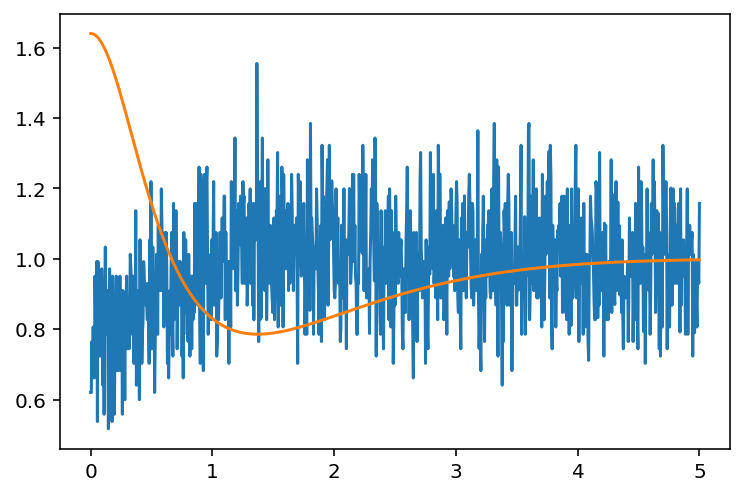

In [30]:
index_of_data_set = 0
plt.plot(np.linspace(0., r_limits[index_of_data_set], len(sims[index_of_data_set]['pcf'])), sims[index_of_data_set]['pcf'])
plt.plot(np.linspace(0., r_limits[index_of_data_set], len(c_list[index_of_data_set])), c_list[index_of_data_set].detach().numpy())

In [31]:
max_count_of_active_threads = 4

def find_optimal_parameters_for_one_data_frame(index, solver_list, simulated_pcf, simulated_populations, results):
    """
    Функция, вычисляющая и записывающая в словарь оптимальные параметры замыкания и прочую сопутствующую информацию для одного набора данных.
    @param index: int -- индекс набора данных, для которого требуется провести расчёт.
    @param solver_list: list(Neumann) -- список всех объектов для вычисления.
    @param simulated_pcf: list(pandas.DataFrame) -- список всех наборов симулированных функций парной корреляции.
    @param simulated_populations: list(float) -- список всех симулированных значений количеств особей.
    @param results: dict -- словарь, куда требуется записать результаты расчётов.
    """
    x, norms, optimal_N, optimal_C, l1_norm_value = solver_list[index].proj_grad()
    results.update(
      {
        index: {
          'alpha': x[0].item(),
          'beta': x[1].item(),
          'gamma': x[2].item(),
          'relative_pcf_error': l1_norm_value / l1_norm(0., list(sims[index]['r'])[-1], torch.tensor(simulated_pcf[index]['pcf'])),
          'relative_population_error': abs((optimal_N.item() - simulated_populations[index]) / simulated_populations[index]),
          'optimal_C': optimal_C,
          'pcf_norms_in_time': norms,
        },
      },
    )

simulated_populations = [
    pd.read_csv(PATH_TO_POPULATION + str(i) + '.csv')['pop'][-1:].item()
    for i in range(1, count_of_data_frames + 1)
]

results_dict = {}
current_count_of_active_threads = 0
first_active_thread_index = 0
threads_list = []
for i in range(0, count_of_data_frames):
    while current_count_of_active_threads > max_count_of_active_threads:
        threads_list[first_active_thread_index].join()
        current_count_of_active_threads -= 1
        first_active_thread_index += 1
  
    threads_list.append(threading.Thread(target=find_optimal_parameters_for_one_data_frame, args=(i, solver_list, sims, simulated_populations, results_dict)))
    threads_list[-1].start()
    current_count_of_active_threads += 1
for i in range(first_active_thread_index, count_of_data_frames):
    threads_list[i].join()

alphas = list()
betas = list()
gammas = list()
norms_list = list()
N_error_list = list()
optimal_C_list = list()

for i in range(0, count_of_data_frames):
    result = results_dict[i]
    alphas.append(result['alpha'])
    betas.append(result['beta'])
    gammas.append(result['gamma'])
    norms_list.append(result['relative_pcf_error'])
    N_error_list.append(result['relative_population_error'])
    optimal_C_list.append(result['optimal_C'])

data_frame = pd.DataFrame(
  {
    'id': list(range(1,len(alphas) + 1)),
    'in_b': [sample['b'].item() for sample in initial_parameters],
    'in_d': [sample['d'].item() for sample in initial_parameters],
    'in_dd': [sample['dd'].item() for sample in initial_parameters],
    'in_sigma_m': [sample['sigma_m'].item() for sample in initial_parameters],
    'in_sigma_w': [sample['sigma_w'].item() for sample in initial_parameters],
    'alpha': alphas,
    'beta': betas,
    'gamma': gammas,
    'pop_error': N_error_list,
    'pcf_error': norms_list,
  },
)
data_frame.to_csv(PATH_TO_OUT_RESULTs, index=False)

In [32]:
for key, value in results_dict.items():
    value['pcf_norms_in_time'] = np.array(value['pcf_norms_in_time'])
    value['pcf_norms_in_time'].shape

In [33]:
%config InlineBackend.figure_format = 'retina'

In [34]:
def myplot(x, y, xlab, ylab, xscale="linear", yscale="log"):
    plt.figure(figsize=(10, 8))
    plt.xscale(xscale)
    plt.yscale(yscale)
    for key in y:
        plt.semilogy(x[key], y[key], label=key)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.legend(loc="best", fontsize=24)
    plt.xlabel(xlab, fontsize=24)
    plt.ylabel(ylab, fontsize=24)

Индекс набора данных: 0
Относительная погрешность, %: 5.071594718482208


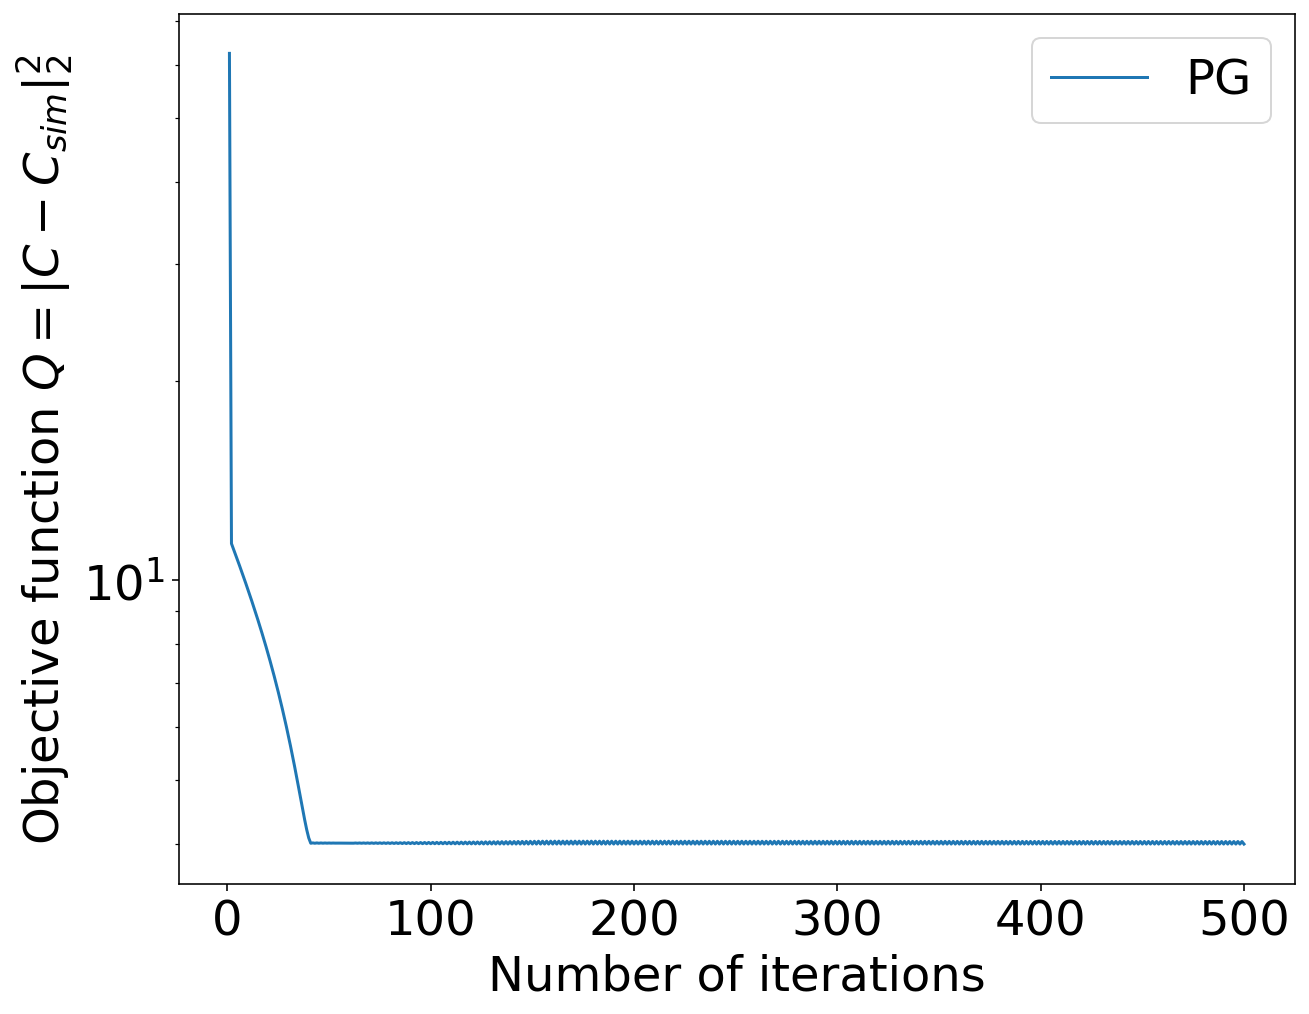

In [35]:
index_of_data_set = 0
norms = results_dict[index_of_data_set]['pcf_norms_in_time']
relative_pcf_error = results_dict[index_of_data_set]['relative_pcf_error']

%matplotlib inline
plt.rc("text", usetex=False)
myplot({"PG": range(1, len(norms) + 1)},
       {"PG": norms}, "Number of iterations",
       r"Objective function $Q = \|C - C_{sim}\|^2_2$")
print(f'Индекс набора данных: {index_of_data_set}')
print(f"Относительная погрешность, %: {relative_pcf_error * 100}")

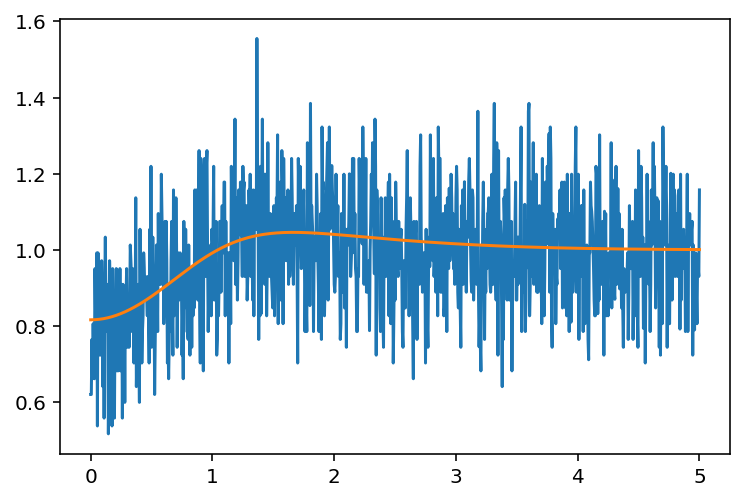

In [36]:
index_of_data_set = 0
optimal_C = optimal_C_list[index_of_data_set]
plt.plot(np.linspace(0., r_limits[index_of_data_set], len(sims[index_of_data_set]['pcf'])), sims[index_of_data_set]['pcf'])
plt.plot(np.linspace(0., r_limits[index_of_data_set], len(optimal_C)), optimal_C.detach().numpy())

    CSV 1:

Variance (исходные данные): 0.01786701058564034
Variance (скользящее среднее): 0.0035565444219168023
Variance (экспоненциальное сглаживание): 0.009739158549413745
Variance (двойное экспоненциальное сглаживание): 0.016266495025145707

MSE (исходные данные): 0.0228015458780097
Simple MSE (исходные данные): 0.0

MSE (скользящее среднее): 0.008117179140164394
Simple MSE (скользящее среднее): 0.01490321407088191

MSE (экспоненциальное сглаживание): 0.01455346795930746
Simple MSE (экспоненциальное сглаживание): 0.00223606722859307

MSE (двойное экспоненциальное сглаживание): 0.02167005522875606
Simple MSE (двойное экспоненциальное сглаживание): 0.002072526431618346



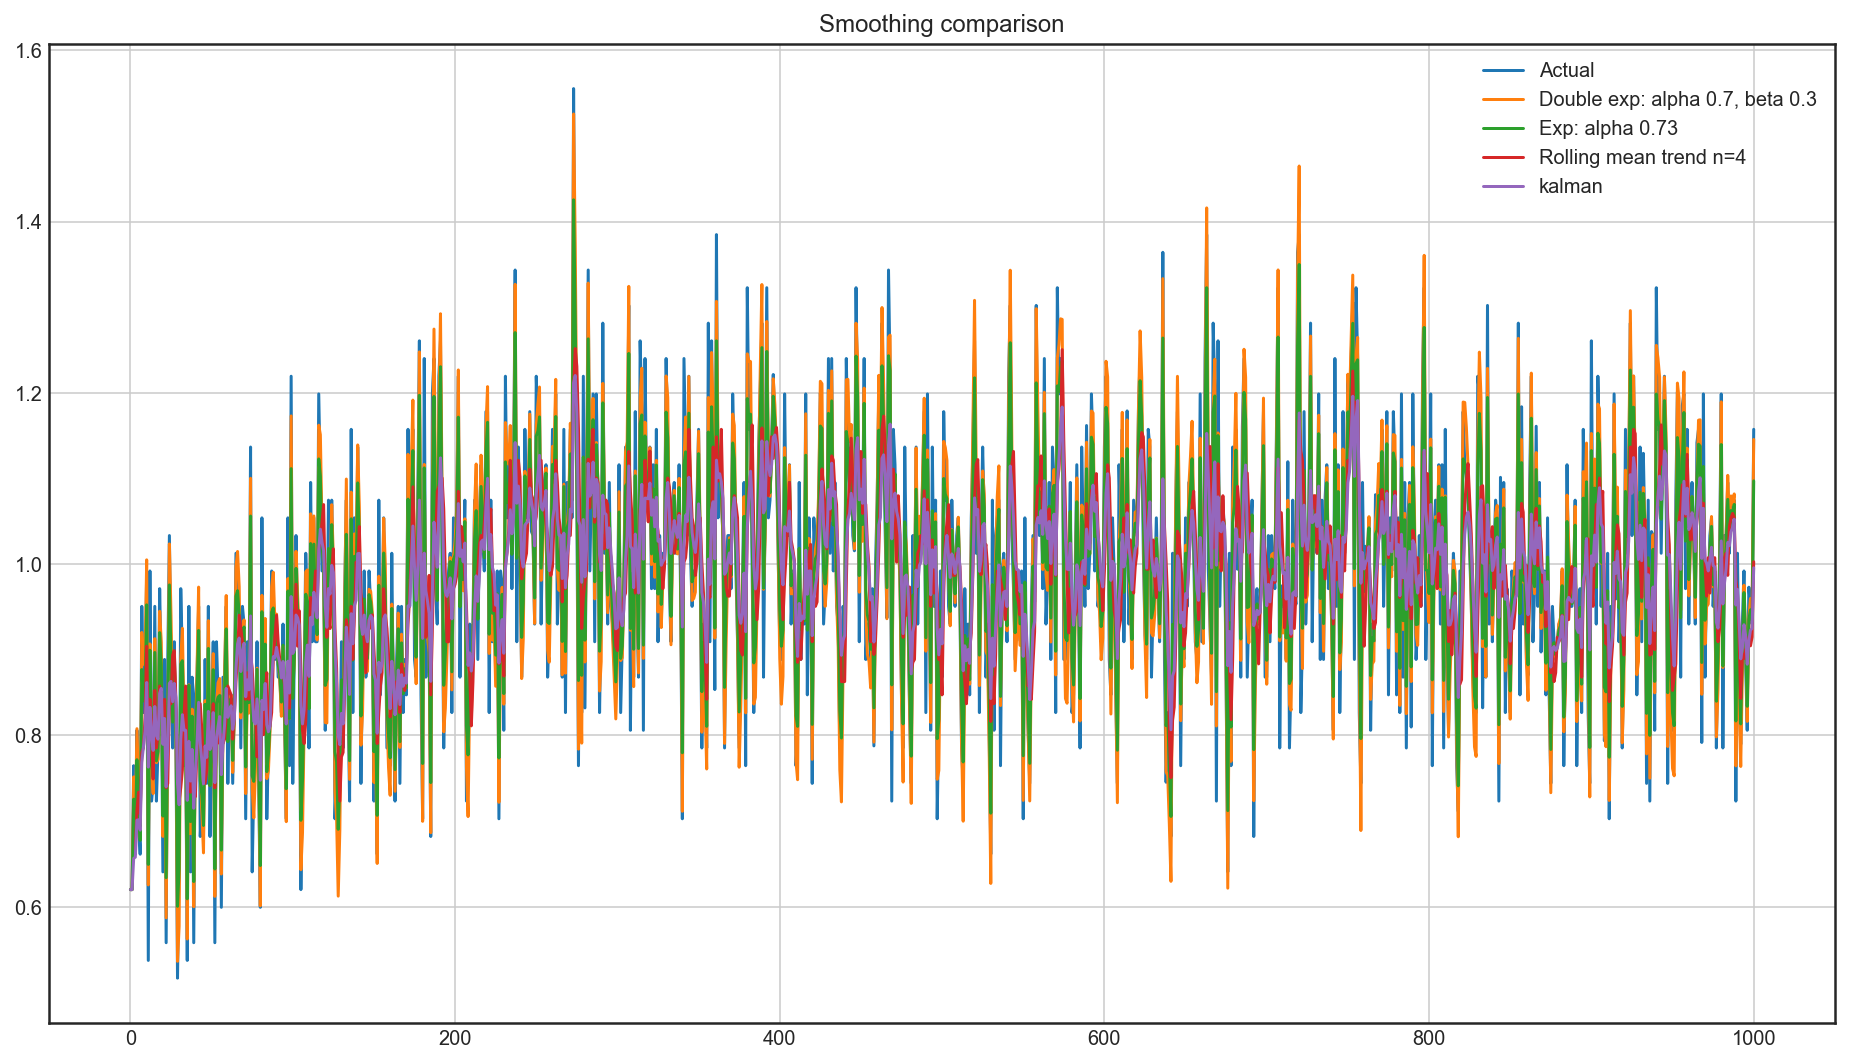

TIME: 0.9773120880126953


In [37]:
moving_average_param = 4
exponential_smoothing_alpha = 0.73
double_exponential_smoothing_alpha = 0.7
double_exponential_smoothing_beta = 0.3

for i in range(len(sims)):
    start = time()
    data = sims[i]['pcf']
    
    
    print(f"    CSV {i + 1}:\n")
    
    estimationOfSmoothings(data, moving_average_param, exponential_smoothing_alpha, double_exponential_smoothing_alpha, double_exponential_smoothing_beta)
    printer(data, exp=exponential_smoothing(data, exponential_smoothing_alpha), avg=moving_average(data, moving_average_param), double_exp=double_exponential_smoothing(data, double_exponential_smoothing_alpha, double_exponential_smoothing_beta), kalman=kalman(data)) 
    #printer(data, exp=exponential_smoothing(data, exponential_smoothing_alpha))

    print("TIME:", time() - start)